In [1]:
from __future__ import print_function

Here are some selected columns:
player -- name of the player
pos -- the position of the player
g -- number of games the player was in
pts -- total points the player scored
fg. -- field goal percentage
ft. -- free throw percentage

In [13]:
import pandas as pd
import numpy as np

nba = pd.read_csv("data/nba_2013.csv")
#nba.head(5)

Creating a new pandas data frame which contains just the point guards from the data set. Point guards are specified as PG in the position column. Assigning the filtered data frame to point_guards.

In [14]:
point_guards = nba[nba['pos'] == 'PG'].copy()
point_guards.head(5)

player pos  age bref_team_id   g  gs    mp   fg  fga    fg.  \
24    D.J. Augustin  PG   26          TOT  71   9  1939  298  718  0.415   
29  Leandro Barbosa  PG   31          PHO  20   0   368   56  131  0.427   
30       Jose Barea  PG   29          MIN  79   1  1471  254  656  0.387   
38   Jerryd Bayless  PG   25          TOT  72  19  1686  248  617  0.402   
50      Steve Blake  PG   33          TOT  55  28  1498  133  353  0.377   

       ...      drb  trb  ast  stl  blk  tov   pf  pts     season  season_end  
24     ...      115  130  313   53    3  125  147  930  2013-2014        2013  
29     ...       32   37   32    7    4   19   30  150  2013-2014        2013  
30     ...      138  154  303   26    0  125  129  660  2013-2014        2013  
38     ...      123  145  194   60    9   82  161  666  2013-2014        2013  
50     ...      146  159  307   54    8  102   85  378  2013-2014        2013  

[5 rows x 31 columns]

In [15]:
# Calculating points per game

point_guards['ppg'] = point_guards['pts'] / point_guards['g']
point_guards[['pts', 'g', 'ppg']].head(5)

pts   g        ppg
24  930  71  13.098592
29  150  20   7.500000
30  660  79   8.354430
38  666  72   9.250000
50  378  55   6.872727

In [16]:
# Dropping the players with zero turnover

point_guards = point_guards[point_guards['tov'] != 0]
point_guards['atr'] = point_guards['ast'] / point_guards['tov']

point_guards[['pts', 'g', 'ppg', 'atr']].head(5)

pts   g        ppg       atr
24  930  71  13.098592  2.504000
29  150  20   7.500000  1.684211
30  660  79   8.354430  2.424000
38  666  72   9.250000  2.365854
50  378  55   6.872727  3.009804

In [17]:
# Point Guards visualization

import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(point_guards['ppg'], point_guards['atr'], c='y')
plt.title("Point Guards")
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)

There seem to be 5 general regions, or clusters, that the point guards fall into (with a few outliers of course!). We can use a technique called clustering to segment all of the point guards into groups of alike players. While regression and other supervised machine learning techniques work well when we have a clear metric we want to optimize for and lots of pre-labelled data, we need to instead use unsupervised machine learning techniques to explore the structure within a data set that doesn't have a clear value to optimize.

Setting up K-Means

1. Assign to clusters
2. Recalculate centroids 


In [20]:
import numpy as np
import random

num_clusters = 5

# Use numpy's random function to generate a list, length: num_clusters, of indices.
random_initial_points = np.random.choice(point_guards.index, size=num_clusters)

# Use the random indices to create the centroids.
centroids = point_guards.ix[random_initial_points]

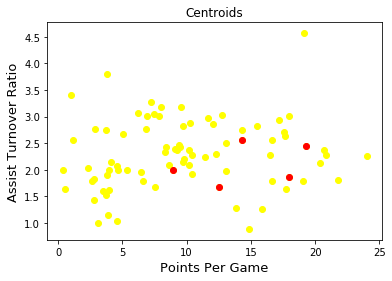

In [19]:
# Visualizing centroids too

import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(point_guards['ppg'], point_guards['atr'], c='yellow')
plt.scatter(centroids['ppg'], centroids['atr'], c='red')
plt.title("Centroids")
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)

In [21]:
def centroids_to_dict(centroids):
    dictionary = dict()
    # Iterating counter we use to generate a cluster_id.
    counter = 0

    # Iterate a pandas data frame row-wise using .iterrows().
    for index, row in centroids.iterrows():
        coordinates = [row['ppg'], row['atr']]
        dictionary[counter] = coordinates
        counter += 1

    return dictionary

centroids_dict = centroids_to_dict(centroids)
print("centroids_dict", centroids_dict)

centroids_dict {0: [6.571428571428571, 1.7833333333333334], 1: [9.743243243243244, 2.1543624161073827], 2: [8.660714285714286, 2.0970873786407767], 3: [10.386363636363637, 1.9310344827586208], 4: [9.743243243243244, 2.1543624161073827]}


In [22]:
# Create the function calculate_distance, which takes in 2 lists 
#(the player's values for ppg and atr and the centroid's values for 
# ppg and atr).

import math

def calculate_distance(centroid, player_values):
    root_distance = 0
    
    for x in range(0, len(centroid)):
        difference = centroid[x] - player_values[x]
        squared_difference = difference**2
        root_distance += squared_difference

    euclid_distance = math.sqrt(root_distance)
    return euclid_distance

q = [5, 2]
p = [3,1]

# Sqrt(5) = ~2.24
print("calculate_distance(q, p)", calculate_distance(q, p))

calculate_distance(q, p) 2.23606797749979


In [23]:
def assign_to_cluster(row):
    lowest_distance = -1
    closest_cluster = -1
    
    for cluster_id, centroid in centroids_dict.items():
        df_row = [row['ppg'], row['atr']]
        euclidean_distance = calculate_distance(centroid, df_row)
        
        if lowest_distance == -1:
            lowest_distance = euclidean_distance
            closest_cluster = cluster_id 
        elif euclidean_distance < lowest_distance:
            lowest_distance = euclidean_distance
            closest_cluster = cluster_id
    return closest_cluster

point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)

In [24]:
# Visualizing clusters
def visualize_clusters(df, num_clusters):
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        plt.scatter(clustered_df['ppg'], clustered_df['atr'], c=colors[n-1])
        plt.xlabel('Points Per Game', fontsize=13)
        plt.ylabel('Assist Turnover Ratio', fontsize=13)

visualize_clusters(point_guards, 5)

In [25]:
# Recalculating centroids

def recalculate_centroids(df):
    new_centroids_dict = dict()
    
    for cluster_id in range(0, num_clusters):
        values_in_cluster = df[df['cluster'] == cluster_id]
        # Calculate new centroid using mean of values in the cluster.
        new_centroid = [np.average(values_in_cluster['ppg']), np.average(values_in_cluster['atr'])]
        new_centroids_dict[cluster_id] = new_centroid
    return new_centroids_dict

centroids_dict = recalculate_centroids(point_guards)
print("centroids_dict:", centroids_dict)

centroids_dict: {0: [4.0518592134551277, 2.1397214936203595], 1: [9.6496567405983775, 2.5648225509486444], 2: [8.332887402123065, 2.5588875011909407], 3: [15.707366080619016, 2.3112202178735699], 4: [nan, nan]}


/Users/Tanvi/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/Tanvi/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


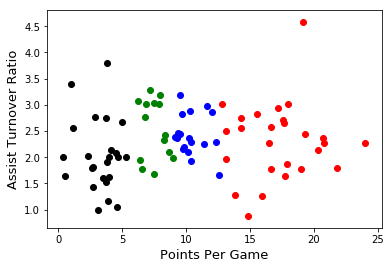

In [26]:
# Repeat step 1

point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)

In [27]:
centroids_dict = recalculate_centroids(point_guards)
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)

/Users/Tanvi/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/Tanvi/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


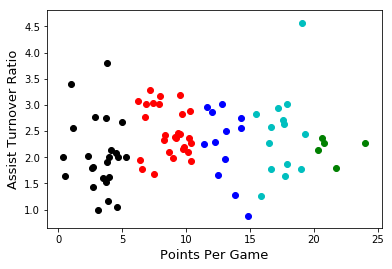

In [28]:
# Implementing the same using K-means from sklearn

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(point_guards[['ppg', 'atr']])
point_guards['cluster'] = kmeans.labels_

visualize_clusters(point_guards, num_clusters)